# Natural language processing model on PennTreeBank dataset

This notebook contains the final architecture of our natural language processing model. Our model is based on [AWD-LSTM model](https://arxiv.org/pdf/1803.08240.pdf).

## Experiment
The goal is generate proteins by using a [Conditional Transformer Language model](https://einstein.ai/presentations/ctrl.pdf). But before doing that, we want to test multiple Recurrent Neural Net Language Models (RNNLM) and benchmark them on the PennTreeBank dataset. Multiple RNNLMs has been trained and tested in order to find the optimal model, that is included in this notebook. To see the other models, please go to the *other_models* folder.

The model accuracy is evaluated in bits per character (BPC), which is a  metric  used  to  describes  theaverage number of bits needed to encode on a character. Accuracy of character-level language models are typically reported in BPC.

At the bottom of the notebook, small sequences of of characters are generated based on the trained model.

## Pretrained weights for the model
The pretrained weights for the model can be found downloaded [here](https://drive.google.com/open?id=19vBZTCBuMbjjYgclTQPA_jlOcTKXK0e5). The models for the save weights are:
* pretrained_char_model_weightdrop_and_tieweights_and_lockdrop_1150.pkl
  * num_hidden: 1150
* pretrained_char_model_weightdrop_and_tieweights_and_lockdrop.pkl
  * num_hidden = 1000
* pretrained_char_model_weightdrop_and_weight_decay_tieweights.pkl
  * num_hidden: 1000
  * uncomment lockdrop
* pretrained_char_model_weightdrop_and_weight_decay.pkl 
  * num hidden: 1000
  * remove weight decay
  * uncomment lockdrop


## Referances

* TorchText: https://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
* paper on DPR regularization: https://arxiv.org/pdf/1808.05908v4.pdf
* tutorial in RNN: https://colab.research.google.com/drive/1jR_DGoVDcxZ104onxTk2C7YeV7vTt1DV#scrollTo=xPVERl79rCYW
* papers with code: https://paperswithcode.com/paper/improved-language-modeling-by-decoding-the
* trellisnet github: https://github.com/locuslab/trellisnet/tree/master/TrellisNet/char_PTB
* Language modeling tutorial in torch: https://mlexplained.com/2018/02/15/language-modeling-tutorial-in-torchtext-practical-torchtext-part-2/
* On saving/loading models: https://pytorch.org/tutorials/beginner/saving_loading_models.html
* awd-lstm github: https://github.com/salesforce/awd-lstm-lm
* RNN training tips: https://towardsdatascience.com/rnn-training-tips-and-tricks-2bf687e67527


## Tips
When running the notebook in colab, insert following javascript code into the console to precent colab from disconnecting after 30min, due to inactivity.

> `function ClickConnect(){
 console.log("Working"); 
 document.querySelector("colab-toolbar-button#connect").click() 
 }
 setInterval(ClickConnect,60000)`






## Importing needed libraries

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import os
import itertools
import warnings

## Check GPU availabiliy

In [2]:
# # check gpu device
print(torch.cuda.device_count()) # how many devices available
print(torch.cuda.get_device_name(torch.cuda.current_device())) # which device currently in use
print(torch.cuda.get_device_capability()) # get the cuda compute capability
print(torch.cuda.get_device_properties(torch.cuda.current_device()))
!nvidia-smi

1
Tesla P100-PCIE-16GB
(6, 0)
_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
Fri Jan  3 20:41:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+--------------------

## Access to Google drive
The access to Google drive is needed to load in the text files and to save the models during training.

In [0]:
# setting up for google drive
from google.colab import drive

In [4]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Defining global hyperparameters

In [0]:
BATCH_SIZE = 128
SEQ_LEN = 150
EPOCHS = 500
USE_GPU = True
CHARACTER_LEVEL = True

### Prepare data and generaing batches of words/characters

In [0]:
import spacy
from spacy.symbols import ORTH
my_tok = spacy.load('en')
my_tok.tokenizer.add_special_case('<eos>', [{ORTH: '<eos>'}])
my_tok.tokenizer.add_special_case('<bos>', [{ORTH: '<bos>'}])
my_tok.tokenizer.add_special_case('<unk>', [{ORTH: '<unk>'}])
def spacy_tok(x):
    return [tok.text for tok in my_tok.tokenizer(x)]

In [0]:
from torchtext import data
TEXT = data.Field(lower=True, tokenize=spacy_tok)
LABEL = data.Field(sequential=False, use_vocab=False)

In [8]:
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchtext.datasets import LanguageModelingDataset
from torchtext.datasets import PennTreebank

if CHARACTER_LEVEL:

  trn_data, vld_data, tst_data = LanguageModelingDataset.splits(path="/content/drive/My Drive/Colab Notebooks/ptb/", text_field=TEXT,
      train='ptb.char.train.txt', validation="ptb.char.valid.txt", test='ptb.char.test.txt', encoding='utf-8')
else:
  trn_data, vld_data, tst_data = LanguageModelingDataset.splits(path="/content/drive/My Drive/Colab Notebooks/ptb/", text_field=TEXT,
      train='ptb.train.txt', validation="ptb.valid.txt", test='ptb.test.txt', encoding='utf-8')


train_iter, valid_iter, test_iter = data.BPTTIterator.splits(
                                        (trn_data,vld_data,tst_data),
                                        batch_size=BATCH_SIZE,
                                        bptt_len=SEQ_LEN, # this is where we specify the sequence length
                                        device=(0 if USE_GPU else -1),
                                        repeat=False)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


## Building the vocabulary
In case of the error: 'BadZipFile: File is not a zip file', when building the vocabulary, try the following.

> `!rm -r .vector_cach`


In [0]:
TEXT.build_vocab(trn_data, vectors="glove.6B.200d")

## Functions from AWD-LSTM
The classes and functions in this section is originally from the github relating the paper [An Analysis of Neural Language Modeling at Multiple Scales, by Stephen Merity, Nitish Shirish Keskar and Richard Socher](https://arxiv.org/pdf/1803.08240v1.pdf) and can be found [here](https://github.com/salesforce/awd-lstm-lm). 

In [0]:
import torch
from torch.nn import Parameter
from functools import wraps

class WeightDrop(torch.nn.Module):
    def __init__(self, module, weights, dropout=0, variational=False):
        super(WeightDrop, self).__init__()
        self.module = module
        self.weights = weights
        self.dropout = dropout
        self.variational = variational
        self._setup()

    def widget_demagnetizer_y2k_edition(*args, **kwargs):
        # We need to replace flatten_parameters with a nothing function
        # It must be a function rather than a lambda as otherwise pickling explodes
        # We can't write boring code though, so ... WIDGET DEMAGNETIZER Y2K EDITION!
        # (╯°□°）╯︵ ┻━┻
        return

    def _setup(self):
        # Terrible temporary solution to an issue regarding compacting weights re: CUDNN RNN
        if issubclass(type(self.module), torch.nn.RNNBase):
            self.module.flatten_parameters = self.widget_demagnetizer_y2k_edition

        for name_w in self.weights:
            print('Applying weight drop of {} to {}'.format(self.dropout, name_w))
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(name_w + '_raw', Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = None
            if self.variational:
                mask = torch.autograd.Variable(torch.ones(raw_w.size(0), 1))
                if raw_w.is_cuda: mask = mask.cuda()
                mask = torch.nn.functional.dropout(mask, p=self.dropout, training=True)

                # change from original awd lstm
                # based on: https://github.com/salesforce/awd-lstm-lm/issues/79
                w = torch.nn.Parameter(mask.expand_as(raw_w) * raw_w)
            else:
                w = torch.nn.Parameter(torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training))

            setattr(self.module, name_w, w)

    def forward(self, *args):
        self._setweights()
        return self.module.forward(*args)

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        if not self.training or not dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
        mask = Variable(m, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        return mask * x

In [0]:

def repackage_hidden(h):
    """Wraps hidden states in new Tensors,
    to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


def batchify(data, bsz, args):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    if args.cuda:
        data = data.cuda()
    return data


def get_batch(source, i, args, seq_len=None, evaluation=False):
    seq_len = min(seq_len if seq_len else args.bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

In [0]:
def embedded_dropout(embed, words, dropout=0.1, scale=None):
  if dropout:
    mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - dropout).expand_as(embed.weight) / (1 - dropout)
    masked_embed_weight = mask * embed.weight
  else:
    masked_embed_weight = embed.weight
  if scale:
    masked_embed_weight = scale.expand_as(masked_embed_weight) * masked_embed_weight

  padding_idx = embed.padding_idx
  if padding_idx is None:
      padding_idx = -1

  X = torch.nn.functional.embedding(words, masked_embed_weight,
    padding_idx, embed.max_norm, embed.norm_type,
    embed.scale_grad_by_freq, embed.sparse
  )
  return X

# LSTM language model

In [0]:
from torch.autograd import Variable as V
class CharModel(nn.Module):
  
  def __init__(self, all_chars,
               ninp, 
               num_hidden=256, 
               num_layers=4,
               weight_drop=0.5,
               batch_size=200,
               tie_weights=False, 
               use_gpu=False):
      
      
    # SET UP ATTRIBUTES
    super().__init__()
    self.weight_drop = weight_drop
    self.num_layers = num_layers
    self.num_hidden = num_hidden
    self.use_gpu = use_gpu
    self.ninp = ninp #embedding dimension 
    self.tie_weights = tie_weights
    self.batch_size = batch_size
    self.lockdrop = LockedDropout()
    self.all_chars = all_chars

    self.embedding = nn.Embedding(self.all_chars, self.ninp)
    
    self.lstms = [nn.LSTM(ninp if l == 0 else num_hidden,
                          num_hidden if l != num_layers - 1 else (ninp if tie_weights else num_hidden), 1 ,dropout=0) for l in range(num_layers)]

    #  the learnable hidden-hidden weights of the layer (W_hi|W_hf|W_hg|W_ho), of shape (4*hidden_size, hidden_size)
    self.lstms = [WeightDrop(rnn, ['weight_hh_l0'], dropout=weight_drop) for rnn in self.lstms]
    
    self.lstms = nn.ModuleList(self.lstms)

    self.dropout = nn.Dropout(weight_drop)
    
    self.fc_linear = nn.Linear(in_features = num_hidden, out_features = self.all_chars)

    if tie_weights:
        self.fc_linear.weight = self.embedding.weight

    self.init_weights()

  def init_weights(self):
    initrange = 0.1
    self.embedding.weight.data.uniform_(-initrange, initrange)
    self.fc_linear.bias.data.fill_(0)
    self.fc_linear.weight.data.uniform_(-initrange, initrange)

  def load_weights(self, model_name):
    self.load_state_dict(torch.load(model_name), strict=False)
   
  def save_weights(self, state, name):
    with open(name, 'wb') as f:
      # d = self.state_dict()
      torch.save(state, f)
      print("Saving model")
  
  def forward(self, input, hidden, return_h=False):

    # uncomment to include embedded dropout
    # emb = embedded_dropout(self.embedding, input, dropout=0.2 if self.training else 0)

    emb = self.embedding(input)

    # utilizing lockdrop
    emb = self.lockdrop(emb, 0.2)

    raw_output = emb
    new_hidden = []
    raw_outputs = []
    outputs = []
    for l, rnn in enumerate(self.lstms):
        current_input = raw_output
        raw_output, new_h = rnn(raw_output, hidden[l])
        new_hidden.append(new_h)
        raw_outputs.append(raw_output)
        if l != self.num_layers - 1:
            # utilizing lockdrop
            raw_output = self.lockdrop(raw_output, 0.25)
            outputs.append(raw_output)
    hidden = new_hidden
    output = raw_output

    linear = self.fc_linear(output.view(output.size(0)*output.size(1),output.size(2))) 

    result = linear.view(output.size(0)*output.size(1), linear.size(1))

    return result, hidden

  def init_hidden(self, batch_size):

    weight = next(self.parameters()).data
    if self.use_gpu:
        hidden = [(weight.new(1, batch_size, self.num_hidden if l != self.num_layers - 1 else (self.ninp if self.tie_weights else self.num_hidden)).zero_().cuda(),
                weight.new(1, batch_size, self.num_hidden if l != self.num_layers - 1 else (self.ninp if self.tie_weights else self.num_hidden)).zero_().cuda())
                for l in range(self.num_layers)]
    else:
        hidden = [(weight.new(1, batch_size, self.num_hidden if l != self.num_layers - 1 else (self.ninp if self.tie_weights else self.num_hidden)).zero_().cuda(),
            weight.new(1, batch_size, self.num_hidden if l != self.num_layers - 1 else (self.ninp if self.tie_weights else self.num_hidden)).zero_().cuda())
            for l in range(self.num_layers)]
    
      
    return hidden
      

In [15]:
weight_matrix = TEXT.vocab.vectors
print(weight_matrix.shape)

torch.Size([52, 200])


## Instantiating the model

In [16]:
model = CharModel(
    all_chars=weight_matrix.size(0),
    ninp = weight_matrix.size(1),
    num_hidden=1150,
    num_layers=3,
    weight_drop=0.5,
    batch_size = BATCH_SIZE,
    tie_weights=True,
    use_gpu=True,
)
print(model)

Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
CharModel(
  (lockdrop): LockedDropout()
  (embedding): Embedding(52, 200)
  (lstms): ModuleList(
    (0): WeightDrop(
      (module): LSTM(200, 1150)
    )
    (1): WeightDrop(
      (module): LSTM(1150, 1150)
    )
    (2): WeightDrop(
      (module): LSTM(1150, 200)
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_linear): Linear(in_features=1150, out_features=52, bias=True)
)


### Counting model parameters

In [17]:
def number_of_paramters(model):
    total_param  = []
    for p in model.parameters():
        total_param.append(int(p.numel()))
    return('Nr of parameters: ', sum(total_param))

number_of_paramters(model)

('Nr of parameters: ', 17900452)

### Defining loss and optimizer

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr= 0.002, weight_decay = 1.2e-6)
criterion = nn.CrossEntropyLoss()

### Training the network

In [0]:
# timekeeping function https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb
def time_since(t):
    now = time.time()
    s = now - t
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def load_checkpoint(model, optimizer, filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'], strict=False)
        optimizer.load_state_dict(checkpoint['optimizer'])
        val_losses = checkpoint['val_losses']
        train_losses = checkpoint['train_losses']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, val_losses, train_losses

In [0]:
# setting up variables
epochs = EPOCHS
batch_size = BATCH_SIZE
seq_len = SEQ_LEN # nr of characters
vocab_size= len(TEXT.vocab)

In [24]:
import time
import matplotlib.pyplot as plt

# on the warning that we are getting see: https://github.com/salesforce/awd-lstm-lm/issues/7 
warnings.filterwarnings(action='once')

start_time = time.time() # start timer

best_val_loss = None

start_epoch = 0
# tracking loss
training_loss, validation_loss = [], []

best_model = "/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop_and_tieweights_and_lockdrop_1150.pkl"

model.train()
if model.use_gpu:
    dvc = torch.cuda.current_device()
    model.cuda()
    print('Using GPU %s with compute capability %s' % (torch.cuda.get_device_name(dvc),torch.cuda.get_device_capability(dvc)))

# check if we have previous saved models in our directory 
# and continue traning them
try:
  model, optimizer, start_epoch, val_losses, train_losses = load_checkpoint(model=model, optimizer=optimizer, filename=best_model)
  training_loss = train_losses
  validation_loss = val_losses
  model.load_weights(best_model)
  print('continue traning on the model weights..')
  print(f'loaded model has been trained for: {start_epoch} epochs.')
except:
  print('failed to load previous model')
  
# substracting the epochs that the model has already trained
epochs = epochs - start_epoch # det her er nok en fejl --------------------------------------------------------------------

# for each epoch
for i in range(epochs):

    # adding the epochs from the loaded session
    i = i+start_epoch

    epoch_training_loss = 0
    epoch_validation_loss = 0

    val_hidden = model.init_hidden(batch_size)

    model.eval()
    
    # for each sentence in validation set
    # for x,y in generate_batches(encoded_test_data, batch_size, seq_len):
    for x in test_iter:

        # check for the last value as it might not be the full seq length -> which will give an error
        if len(x.text)  == SEQ_LEN:

            if model.use_gpu:
                inputs = x.text.cuda()
                targets = x.target.cuda()
            else:
                inputs = x.text
                targets = x.target
                
            # avoid bagpropagating all the way to the beginning
            val_hidden = repackage_hidden(val_hidden)
            
            lstm_output, val_hidden = model.forward(inputs,val_hidden)

            val_loss = criterion(lstm_output, targets.view(batch_size*seq_len).long())

            epoch_validation_loss += val_loss.item()

    model.train()
    
    hidden = model.init_hidden(batch_size)
    
    # for x,y in generate_batches(encoded_train_data, batch_size, seq_len):
    for y in train_iter:
    # for y in itertools.islice(train_iter, 500):

        # check for the last value as it might not be the full seq length -> which will give an error
        if len(y.text)  == SEQ_LEN:

          if model.use_gpu:
              inputs = y.text.cuda()
              targets = y.target.cuda()
          else:
              inputs = y.text
              targets = y.target
            
              
          # Reset Hidden State
          # If we dont' reset we would backpropagate through all training history
          # hidden = tuple([state.data for state in hidden])
          hidden = repackage_hidden(hidden)

          model.zero_grad()
          
          lstm_output, hidden = model.forward(inputs,hidden)

          loss = criterion(lstm_output, targets.view(batch_size*seq_len).long())
          # loss = criterion(lstm_output.view(-1,vocab_size), targets.view(-1))
          epoch_training_loss += loss.item()
          
          loss.backward()
          
          # clipping the grapdient to avoid possible exploding gradient problem.
          nn.utils.clip_grad_norm_(model.parameters(),max_norm=5)
          
          optimizer.step()
        
    # calculating the avg. loss pr/epoch and saving it to a list.
    # we are substracting 1, since the last line does not have the correct sequence length.
    # this could be done more elegantly
    training_loss.append(epoch_training_loss/(len(train_iter)-1))
    validation_loss.append(epoch_validation_loss/(len(test_iter)-1))

    # Print loss every x epochs
    if i % 1 == 0:
        state = {'epoch': i + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'val_losses': validation_loss, 'train_losses': training_loss}
        model.save_weights(state, best_model)

        if CHARACTER_LEVEL:
          # showing bits per characters - relevant for character level examination
          print(f'Time {time_since(start_time)}, Epoch {i+1}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}, bpc: {validation_loss[-1] / np.log(2)}')
        else:
          # showing perplexity - relevant for word level examination
          print(f'Time {time_since(start_time)}, Epoch {i+1}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}, ppl: {np.exp(validation_loss[-1])}')
        
print("--- training time: %s seconds ---" % (time_since(start_time)))

print("Input sentence")
print(inputs)

print("Target sentence")
print(targets)

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

outout removed


/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1268: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


## Evaluate the training
We evaluate the models based on the saved weights. First import the saved model (if needed) and plot the training/validation loss from the tranining of the model.


In [22]:
# load and print model
import matplotlib.pyplot as plt
best_model = "/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop_and_tieweights_and_lockdrop_1150.pkl"

model, optimizer, start_epoch, val_losses, train_losses = load_checkpoint(model=model, optimizer=optimizer, filename=best_model)

=> loading checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop_and_tieweights_and_lockdrop_1150.pkl'
=> loaded checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop_and_tieweights_and_lockdrop_1150.pkl' (epoch 473)


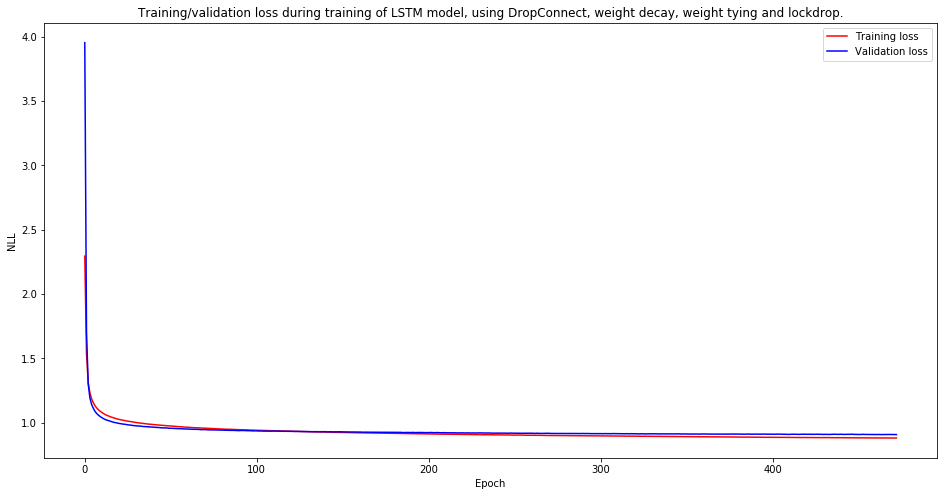

In [23]:
# Plot training and validation loss
epoch = np.arange(len(val_losses))
plt.figure(figsize=(16,8))
plt.plot(epoch, train_losses, 'r', label='Training loss',)
plt.plot(epoch, val_losses, 'b', label='Validation loss')
plt.legend()
plt.title("Training/validation loss during training of LSTM model, using DropConnect, weight decay, weight tying and lockdrop.")
plt.xlabel('Epoch'), plt.ylabel('NLL')

plt.savefig('/content/drive/My Drive/Colab Notebooks/training_validation loss during training of LSTM model using DropConnect weight decay weight tying and lockdrop.png')
plt.show()

Getting the lowest validation loss.

In [24]:
def get_lowest_bpc(val_losses=val_losses):
    return min(val_losses) / np.log(2)

get_lowest_bpc(val_losses)

1.3105184213726693

# Generate predictions
We generate some text based on the model we have trained.

In [0]:
# emptying cache to avoid ot of memory errors for big models
# if this is not enough and the CUDA out of memory appears, restart the notebook and load in the model again.
torch.cuda.empty_cache()

In [0]:
from tqdm import tqdm
import random

warnings.filterwarnings('ignore')

test_preds = []
def predict_next_character(model, char, hidden=None, k=1):

  # getting the character id from the vocabulary
  char_id = TEXT.vocab.stoi[char]

  char_id = np.array([[char_id]])

  char_id = torch.from_numpy(np.array(char_id))

  if model.use_gpu:
    char_id = char_id.cuda()

  # avoid backpropagating over the entire sequence
  repackage_hidden(hidden)

  preds, hidden = model(char_id, hidden)

  # getting a probability distribution of the possible next characters/words
  probs = F.softmax(preds, dim=1).data

  if model.use_gpu:
    probs = probs.cpu()

  probs, index_positions = probs.topk(k) # change k to variable

  index_positions = index_positions.transpose(0, 1).contiguous().view(-1)

  probs = probs.numpy().flatten()

  probs = probs/probs.sum()

  char_id = np.random.choice(index_positions, p=probs)

  # converting from interger to string
  char = TEXT.vocab.itos[char_id]

  return char, hidden

In [0]:
def generate_text(model, size, seed='the', k=1): # k is the top most probabilities characters
  output_chars = []
  if model.use_gpu:
    model.cuda()
  else:
    model.cpu()
  # setting the model in evalluating state
  model.eval()

  if CHARACTER_LEVEL: 
    output_chars = [c for c in seed]
  else:
    output_chars.append(seed)
    
  hidden = model.init_hidden(1)

  # starting predictions from the seed
  for char in seed:
    char, hidden = predict_next_character(model, char, hidden, k=k)
  output_chars.append(char)

  # generating new text
  for i in range(size): 
    char, hidden = predict_next_character(model, output_chars[-1], hidden, k=k)


    output_chars.append(char)

  return ''.join(output_chars)

In [31]:
print(generate_text(model, 100, seed='the_', k=3))

the_company_said_the_acquisition_was_too_much_important_that_in_the_coming_months<eos> analysts_and_analysts_


## Evaluate the other models
Let's take a quick look at how the other models trained by loading in their weighs, plotting their losses during training and calculating the BPC.

### Training/validation loss during training of LSTM model using:
* DropConnect 
* weight decay
* weight tying 
* lockdrop 
* hidden: 1000

The model need to fit the parameters saved with the weights.

In [33]:
model = CharModel(
    all_chars=weight_matrix.size(0),
    ninp = weight_matrix.size(1),
    num_hidden=1000,
    num_layers=3,
    weight_drop=0.5,
    batch_size = BATCH_SIZE,
    tie_weights=True,
    use_gpu=True,
)
print(model)

Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
CharModel(
  (lockdrop): LockedDropout()
  (embedding): Embedding(52, 200)
  (lstms): ModuleList(
    (0): WeightDrop(
      (module): LSTM(200, 1000)
    )
    (1): WeightDrop(
      (module): LSTM(1000, 1000)
    )
    (2): WeightDrop(
      (module): LSTM(1000, 200)
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_linear): Linear(in_features=1000, out_features=52, bias=True)
)


In [34]:
# load and print model
import matplotlib.pyplot as plt
best_model = "/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop_and_tieweights_and_lockdrop.pkl"

model, optimizer, start_epoch, val_losses, train_losses = load_checkpoint(model=model, optimizer=optimizer, filename=best_model)

=> loading checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop_and_tieweights_and_lockdrop.pkl'
=> loaded checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop_and_tieweights_and_lockdrop.pkl' (epoch 500)


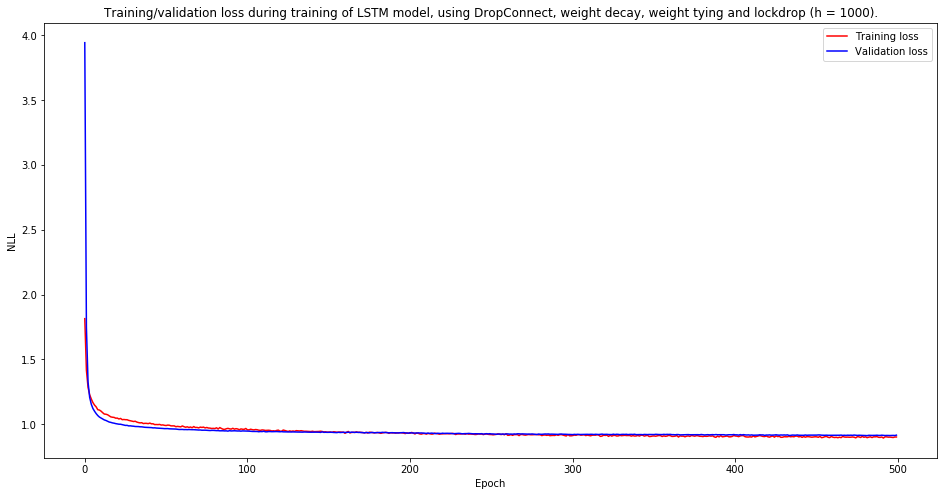

In [35]:
# Plot training and validation loss
epoch = np.arange(len(val_losses))
plt.figure(figsize=(16,8))
plt.plot(epoch, train_losses, 'r', label='Training loss',)
plt.plot(epoch, val_losses, 'b', label='Validation loss')
plt.legend()
plt.title("Training/validation loss during training of LSTM model, using DropConnect, weight decay, weight tying and lockdrop (h = 1000).")
plt.xlabel('Epoch'), plt.ylabel('NLL')

plt.savefig('/content/drive/My Drive/Colab Notebooks/training_validation loss during training of LSTM model using DropConnect weight decay weight tying and lockdrop and h=1000.png')
plt.show()

Calculating BPC

In [36]:
get_lowest_bpc(val_losses)

1.3165259884762441

### Training/validation loss during training of LSTM model using:
* DropConnect 
* weight decay
* weight tying 
* hidden: 1000

In [37]:
# load and print model
import matplotlib.pyplot as plt
best_model = "/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop_and_tieweights.pkl"

model, optimizer, start_epoch, val_losses, train_losses = load_checkpoint(model=model, optimizer=optimizer, filename=best_model)

=> loading checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop_and_tieweights.pkl'
=> loaded checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop_and_tieweights.pkl' (epoch 413)


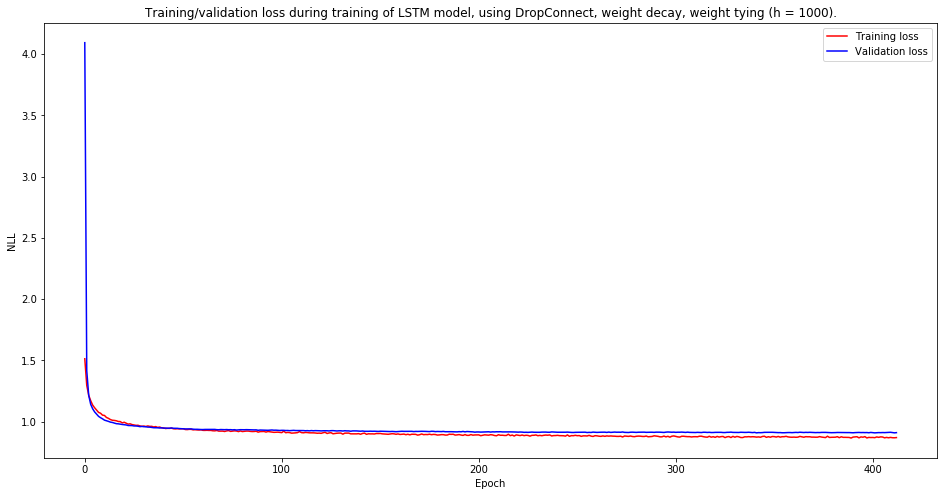

In [38]:
# Plot training and validation loss
epoch = np.arange(len(val_losses))
plt.figure(figsize=(16,8))
plt.plot(epoch, train_losses, 'r', label='Training loss',)
plt.plot(epoch, val_losses, 'b', label='Validation loss')
plt.legend()
plt.title("Training/validation loss during training of LSTM model, using DropConnect, weight decay, weight tying (h = 1000).")
plt.xlabel('Epoch'), plt.ylabel('NLL')

plt.savefig('/content/drive/My Drive/Colab Notebooks/training_validation loss during training of LSTM model using DropConnect weight decay weight tying h=1000.png')
plt.show()

Calculating BPC

In [39]:
get_lowest_bpc(val_losses)

1.3113175798861894

### Training/validation loss during training of LSTM model using:
* DropConnect 
* weight decay
* hidden: 1000

In [40]:
model = CharModel(
    all_chars=weight_matrix.size(0),
    ninp = weight_matrix.size(1),
    num_hidden=1000,
    num_layers=3,
    weight_drop=0.5,
    batch_size = BATCH_SIZE,
    tie_weights=False,
    use_gpu=True,
)
print(model)

Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
CharModel(
  (lockdrop): LockedDropout()
  (embedding): Embedding(52, 200)
  (lstms): ModuleList(
    (0): WeightDrop(
      (module): LSTM(200, 1000)
    )
    (1): WeightDrop(
      (module): LSTM(1000, 1000)
    )
    (2): WeightDrop(
      (module): LSTM(1000, 1000)
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_linear): Linear(in_features=1000, out_features=52, bias=True)
)


In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr= 0.002, weight_decay = 1.2e-6)
criterion = nn.CrossEntropyLoss()

In [42]:
# load and print model
import matplotlib.pyplot as plt
best_model = "/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop_and_weight_decay.pkl"

model, optimizer, start_epoch, val_losses, train_losses = load_checkpoint(model=model, optimizer=optimizer, filename=best_model)

=> loading checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop_and_weight_decay.pkl'
=> loaded checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop_and_weight_decay.pkl' (epoch 269)


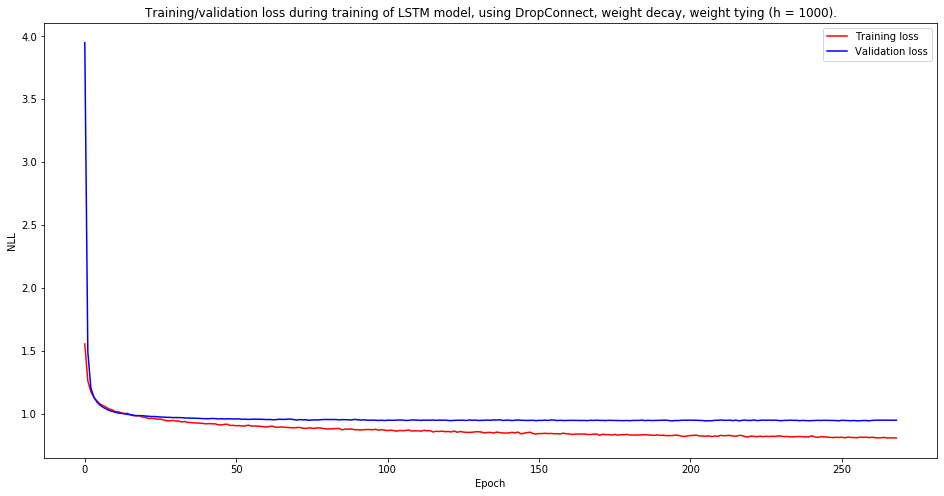

In [43]:
# Plot training and validation loss
epoch = np.arange(len(val_losses))
plt.figure(figsize=(16,8))
plt.plot(epoch, train_losses, 'r', label='Training loss',)
plt.plot(epoch, val_losses, 'b', label='Validation loss')
plt.legend()
plt.title("Training/validation loss during training of LSTM model, using DropConnect, weight decay, weight tying (h = 1000).")
plt.xlabel('Epoch'), plt.ylabel('NLL')

plt.savefig('/content/drive/My Drive/Colab Notebooks/training_validation loss during training of LSTM model using DropConnect weight decay weight tying h=1000.png')
plt.show()

### Training/validation loss during training of LSTM model using:
* DropConnect 
* hidden: 1000

In [47]:
# load and print model
import matplotlib.pyplot as plt
best_model = "/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop.pkl"

model, optimizer, start_epoch, val_losses, train_losses = load_checkpoint(model=model, optimizer=optimizer, filename=best_model)

=> loading checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop.pkl'
=> loaded checkpoint '/content/drive/My Drive/Colab Notebooks/nets/pretrained_char_model_weightdrop.pkl' (epoch 204)


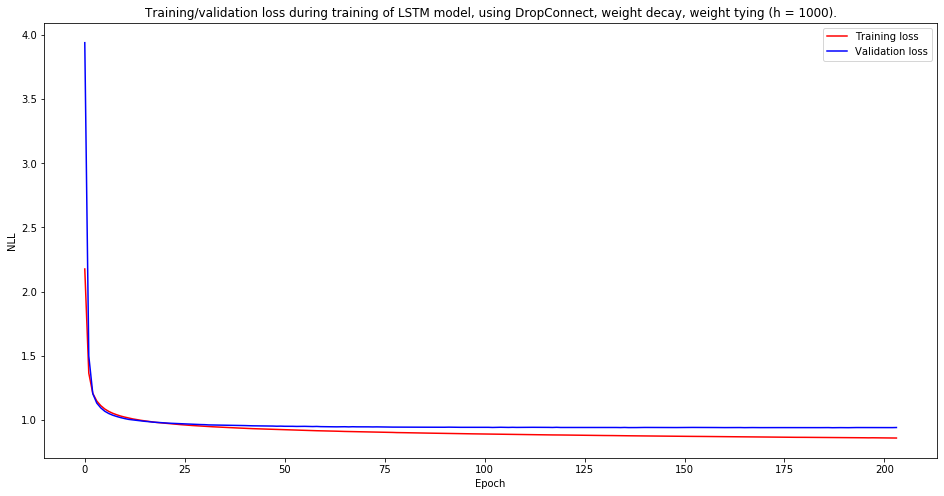

In [48]:
# Plot training and validation loss
epoch = np.arange(len(val_losses))
plt.figure(figsize=(16,8))
plt.plot(epoch, train_losses, 'r', label='Training loss',)
plt.plot(epoch, val_losses, 'b', label='Validation loss')
plt.legend()
plt.title("Training/validation loss during training of LSTM model, using DropConnect, weight decay, weight tying (h = 1000).")
plt.xlabel('Epoch'), plt.ylabel('NLL')

plt.savefig('/content/drive/My Drive/Colab Notebooks/training_validation loss during training of LSTM model using DropConnect weight decay weight tying h=1000.png')
plt.show()

In [49]:
get_lowest_bpc(val_losses)

1.353995605600761